In this assignment, you will apply the models evaluation, validation, and ensemble learning we discussed and practiced in M3 to your own project.

Write your code in a jupyter notebook named P3_evaluation.ipynb
Submit P3_evaluation.ipynb to Gradescope: [P3_evaluation](https://www.gradescope.com/courses/694915/assignments)
    

Note that in your implementation, we recommend you to revisit the tree-based models and linear models you have implemented to:

-    re-calculate your model performance using different evaluation metrics (e.g., confusion matrix, precision/recall/f1, roc_auc_score/roc_curve)
-    interpret the model performance to understand the advantage and disadvantage of each model
-    apply gridsearchcv to find the most suitable hyperparameters for each model
-    with the best hyperparameter setting you find in last step, apply KFold cross validation to validate your model performance on each fold
-    [optional] explore one of the ensemble learning methods to improve your model performance

Please remember to comment on important steps (i.e., write down your observations and thoughts)

In [1]:
# importing important libraries
import os
import numpy as np
import pandas as pd
import re, string

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# for validation

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time

# for ensemble
from sklearn import datasets
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# for NLP
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tqdm import tqdm
from bs4 import BeautifulSoup

# for viz
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Data Set up


In [2]:
# get the Reddit data
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\newest_all_df.pkl")

When doing work for another class (content analysis), I noticed that the "ground truth" labels for my data were in fact incorrect. I had previous used a regular expression to find posts with user flairs that contained specific words I believed would capture the full range of individuals identifying as adoptees. However, I noticed some extremely obvious discrepancies like not picking up posts whose flair was "Transracial Adoptee". I initially did not notice this error because of the large number of rows (50k), and only visually inspected the first 100 or so and the last handful. However upon further inspection I soon realized my regular expression was faulty. I have since switched to a much more explicit expression (ie listing out every single flair I think is related to adoptees). I had to visually inspect and categorize around 470 unique flairs to do so. Thus I hope that these ground truth data labels are much more accurate than previous attempts. Furthermore the distribution of adoptee and non adoptee posts has since changed. Previously this was around a 2/3 and 1/3 split in favor of non adoptee posts. Now, however, it seems more akin to 2/5 and 3/5 in favor of adoptees (as can be seen in the cells below)

In [3]:
# have changed how I have labeled is_adoptee label a little since last time
# the below code will give me all ground truth labels 0 for non adoptee, 1 for adoptee
truth_df = all_df[(all_df.is_adoptee < 2) & (all_df.num_tokens > 25)]

### Helper Functions

In [4]:
# use for model evaluation of classifiers

def mod_eval(clf, X_test, y_test):
    """
    Given a classifier and data print out a classification report and 
    a corresponding ROC-AUC chart to visualize model performance.

    Inputs:
        clf: an sklearn classifier 
        X_test: an array like structure of model testing features 
        y_test: an array like structure of model testing y's
    Return nothing, prints classification report table and plots a ROC-AUC curve
    """
    # find yhats for testing data
    y_pred_test = clf.predict(X_test)
    # model performance on testing set
    print(classification_report(y_test, y_pred_test),"\n")
    
    con_mat = confusion_matrix(y_test, y_pred_test)
    # help displaying a confusion matrix with labels
    # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    labels = ['Non-adoptees', 'Adoptees']
    cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
    cmd.plot(cmap="crest")

    # this portion of the code was aided with the help of Chat GPT
    # https://chat.openai.com/share/c4379ee5-9d59-4632-84aa-6a14b1aaec02

    # find the y_probs
    y_probs = clf.predict_proba(X_test)[:, 1]
    fprs, tprs, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fprs, tprs)
    plt.figure()
    plt.plot(fprs, tprs, color='darkred', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()
    return


def vect_and_split(vectorizer, feature_col, y_col):
    """
    Vectorizers a column of text data features, and performs a test-train split
    Inputs:
        vectorizer: the vectorizer to vectorize the feature column
        feature_col: the column of textual data that will act as the features
        y_col: the column containing the y's
    Outputs:
        train and test split for X and y
    """

    # convert the cleaned reviews to vectors
    X = vectorizer.fit_transform(feature_col)
    y = y_col

    # train test split
    train_idx, test_idx = train_test_split(np.arange(truth_df.shape[0]), test_size=0.2, 
                                        shuffle=True, random_state=42)

    X_train = X[train_idx]
    y_train = y.iloc[train_idx]

    X_test = X[test_idx]
    y_test = y.iloc[test_idx]

    return X_train, y_train, X_test, y_test

### Let's do train test split for count vectorizer data

In [5]:
# since I am dealing with textual data, we need to vectorize the text to find 
# useful insights into this high dimensional data

stop_words = stopwords.words('english')
c_vectorizer = CountVectorizer(lowercase=True, stop_words=stop_words, 
                               max_df=0.9, min_df=3, ngram_range=(1,1))

X_train, y_train, X_test, y_test = vect_and_split(c_vectorizer, 
                                                  truth_df.cleaner_text, 
                                                  truth_df.is_adoptee)

#### Decision Trees

              precision    recall  f1-score   support

           0       0.56      0.55      0.55      3175
           1       0.71      0.72      0.71      4799

    accuracy                           0.65      7974
   macro avg       0.64      0.63      0.63      7974
weighted avg       0.65      0.65      0.65      7974
 



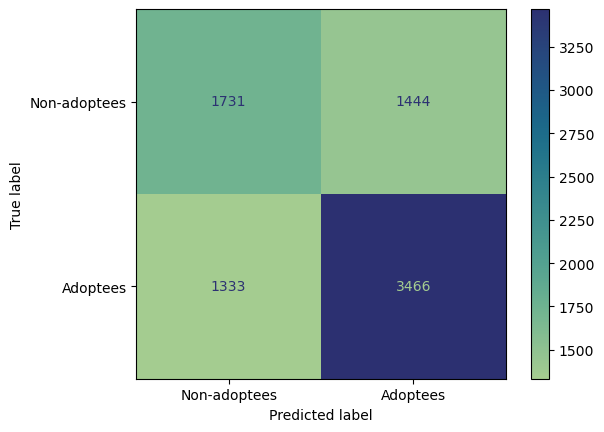

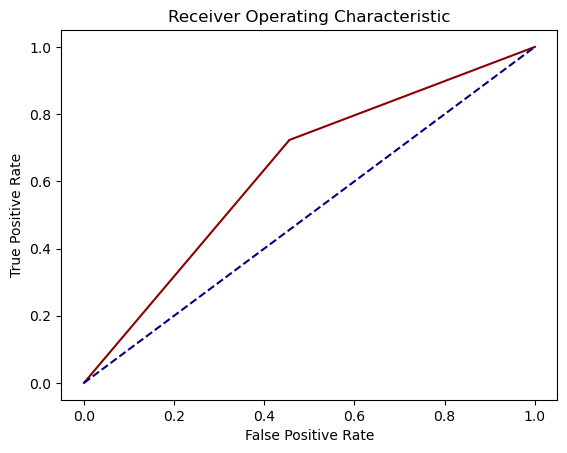

In [6]:
# let's run the default decision tree classifier
dt_clf = DecisionTreeClassifier(criterion="gini",
                                random_state=42).fit(X_train, y_train)

mod_eval(dt_clf, X_test, y_test)

From the above, we see that using the CountVectorizer and the base DT classifier, our model does not perform extremely well. The accuracy is only 65% which is marginally better than a model that predicts all adoptees for the testing set. We see that a visual inspection of the curve demonstrates that the model is marginally better than one that randomly guesses which label to assign to each Reddit post. Furthermore we see that the precision, recall, and f1 score for adoptee posts (1) is higher than non adoptee posts (0). With regards to precision this means that the model accurately finds true adoptee posts from all predicted as such better than non adoptee posts. For recall we also see that the model finds more true adoptee posts from all truly adoptee posts than non adoptee posts as well.

              precision    recall  f1-score   support

           0       0.62      0.39      0.48      3175
           1       0.68      0.84      0.75      4799

    accuracy                           0.66      7974
   macro avg       0.65      0.62      0.62      7974
weighted avg       0.66      0.66      0.64      7974
 



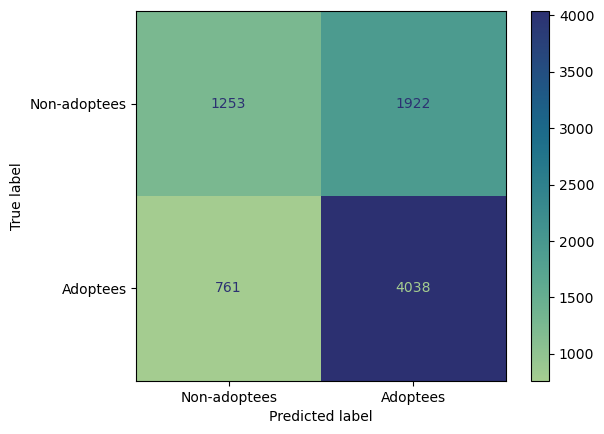

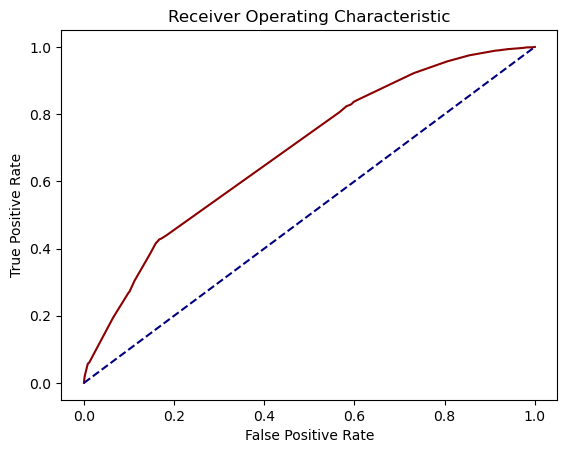

In [7]:
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=10,
                                random_state=42, max_leaf_nodes=50,
                                max_features=.8).fit(X_train, y_train)

mod_eval(dt_clf, X_test, y_test)

We see minor improvements in the overall accuracy of the model. However, we see significant drops in the recall for non adoptee posts. As we see this drop for non adoptee posts we see a large increase in recall for adoptee posts (.91). We see some improvements in precision for non adoptees as well, while for adoptees it is slightly worse than before. A tradeoff of this model is evidently that it increases accuracy of the model and recall for adoptee posts by sacrificing its ability to find true non adoptee posts (recall).

#### Let us check logistic regression as well

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      3175
           1       0.77      0.77      0.77      4799

    accuracy                           0.72      7974
   macro avg       0.71      0.71      0.71      7974
weighted avg       0.72      0.72      0.72      7974
 



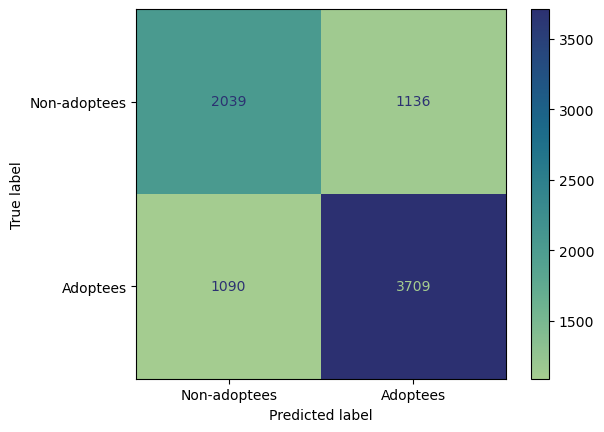

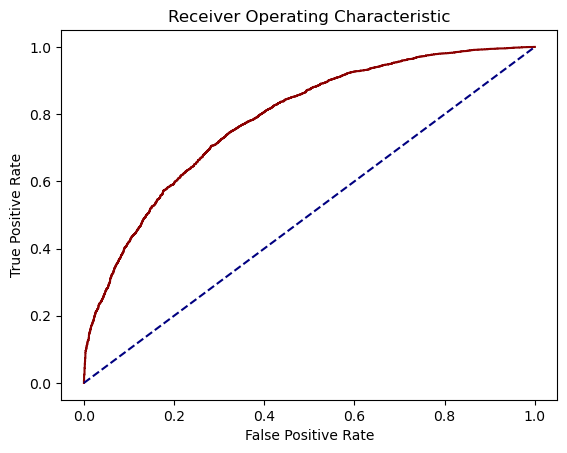

In [8]:
lr_clf = LogisticRegression(penalty=None).fit(X_train, y_train)
mod_eval(lr_clf , X_test, y_test)

We see that a basic logistic regression with no regularization penalties performs better than either of the decision tree classifiers from above in terms of overall model accuracy. Comapring the F1 scores demonetrates that this logistic regression performs better or the same as either of the DT classifiers. We can also visually see from the ROC curve that the curve has a larger AUC.

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      3175
           1       0.76      0.85      0.80      4799

    accuracy                           0.75      7974
   macro avg       0.74      0.72      0.73      7974
weighted avg       0.74      0.75      0.74      7974
 



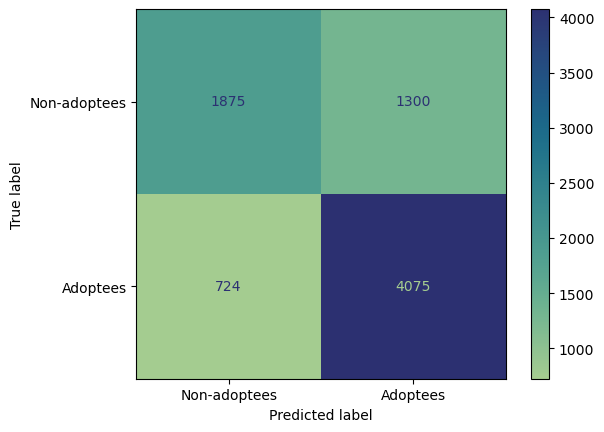

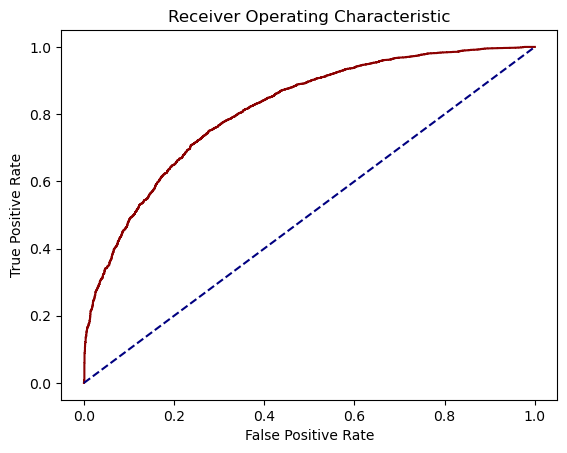

In [9]:
lr_clf = LogisticRegression(penalty="elasticnet", 
                            C=.1, solver="saga", 
                            l1_ratio=0.5).fit(X_train, y_train)
mod_eval(lr_clf , X_test, y_test)

By performing both L1 and L2 reguarlization, we see marginal improvements in the logistic regression classifier. The precision for both adoptee and non adoptee posts are much closer to each other than in any other previous model. Recall still appears to be a problem for non adoptee posts. The recall for adoptees is much higher than for non adoptees. Similar to the second DT classifier, this model improves accuracy at the cost of worse recall for non adoptee posts. This means there is a higher false positive rate.

#### Let's try some grid search

In [10]:
# takes 17 minutes to run
lr_clf = LogisticRegression(random_state=42)
# let's look at both regularization techniques, multiples values of C, and two solvers
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 0.1, 1, 10],
              'solver': ['liblinear',"saga"]} # 2*4*2 = 16 combinations

grid_cv = GridSearchCV(estimator = lr_clf, 
                       param_grid = parameters, 
                       cv=5).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.7476093431572347


We see that the best logistic regression model is with the above parameters and obtains an accuracy of .75

In [ ]:
# get the best model from grid CV
lr_clf = LogisticRegression(random_state=42, 
                            C=grid_cv.best_params_["C"],
                            penalty=grid_cv.best_params_["penalty"],
                            solver=grid_cv.best_params_["solver"]).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.69      0.57      0.63      3175
           1       0.75      0.83      0.79      4799

    accuracy                           0.73      7974
   macro avg       0.72      0.70      0.71      7974
weighted avg       0.72      0.73      0.72      7974



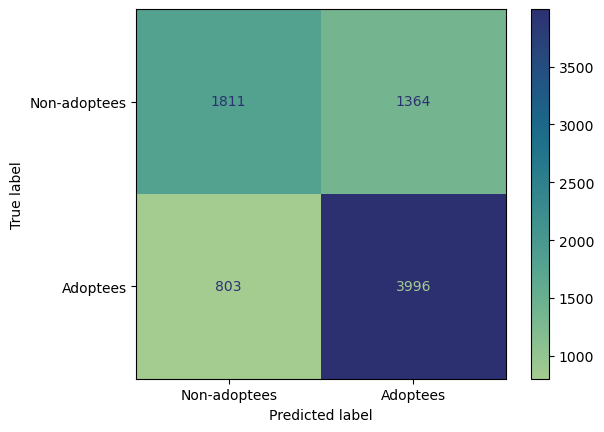

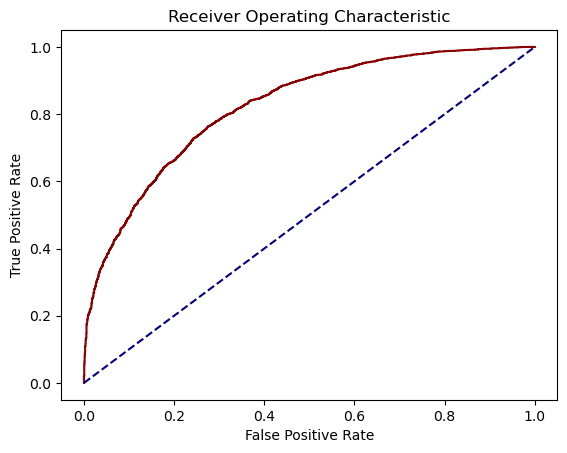

In [ ]:
# run 10-fold validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred_test = cross_val_predict(lr_clf, X_test, y_test, cv=kf)


### EVALUATION ###

# evaluation scores
report = classification_report(y_test, y_pred_test)
print(report)

# confusion matrix
con_mat = confusion_matrix(y_test, y_pred_test)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# this portion of the code was aided with the help of Chat GPT
# https://chat.openai.com/share/c4379ee5-9d59-4632-84aa-6a14b1aaec02

# find the y_probs
y_probs = lr_clf.predict_proba(X_test)[:, 1]
fprs, tprs, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fprs, tprs)
plt.figure()
plt.plot(fprs, tprs, color='darkred', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

The above demonstrates that performing 10 fold cross validation on the best model, the average accuracy is still around 73%. Similar to other models, we see that the average score for all k-fold models has low non adoptee recall, increasing the chance of type I errors.  

### Let's try using a different vectorizer: TF/IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words, max_df=0.9, min_df=3, ngram_range=(1,2))

X_train, y_train, X_test, y_test = vect_and_split(tfidf_vectorizer, 
                                                  truth_df.cleaner_text, 
                                                  truth_df.is_adoptee)

#### DTs with TF/IDF

              precision    recall  f1-score   support

           0       0.63      0.39      0.48      3175
           1       0.68      0.85      0.75      4799

    accuracy                           0.67      7974
   macro avg       0.65      0.62      0.62      7974
weighted avg       0.66      0.67      0.64      7974
 



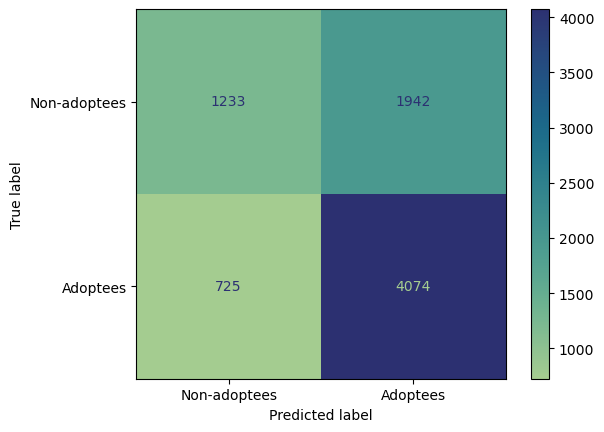

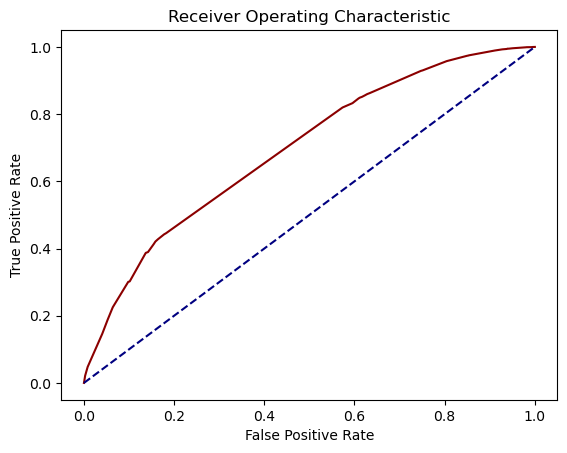

In [ ]:
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=10,
                                random_state=42, max_leaf_nodes=50,
                                max_features=.8).fit(X_train, y_train)

mod_eval(dt_clf, X_test, y_test)

We see that with the TF/IDF vectorizer, the model accuracy goes down by a little. Compared to counts vectorizer there are only minor differences. Precision for non adoptees goes down while recall increases. Recall for adoptee posts also goes down. The same tradeoffs apply as the corresponding model for countvectorizer

#### Log Regression with TF/IDF

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      3175
           1       0.79      0.83      0.81      4799

    accuracy                           0.77      7974
   macro avg       0.76      0.75      0.75      7974
weighted avg       0.76      0.77      0.77      7974
 



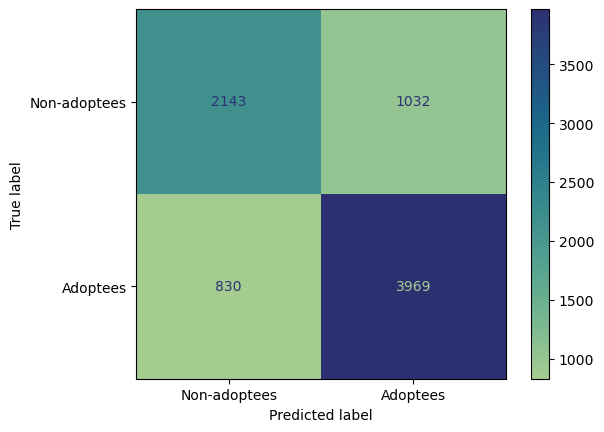

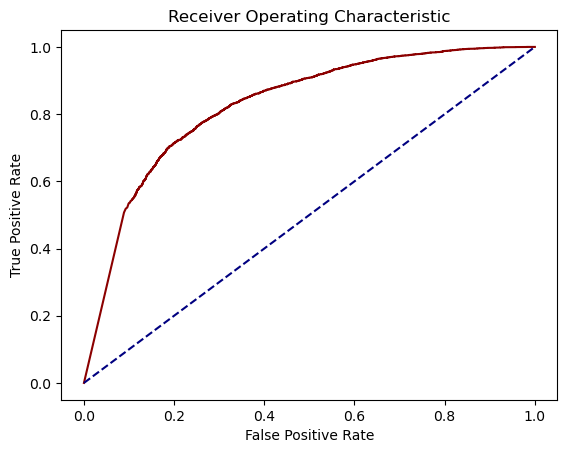

In [ ]:
lr_clf = LogisticRegression(penalty=None).fit(X_train, y_train)
mod_eval(lr_clf , X_test, y_test)

We see that the model accuracy is similar to using CountVectorizer. When comparing the analagous model for countvectorizer, the F1 scores for both labels does not significantly change much (though non adoptee is a bit higher here). We still see that the major tradeoff with logistic regression model like this is that there is low recall for negative cases (more false positives).

#### Let's try grid search and cross validation

In [ ]:
# takes 17 minutes to run
lr_clf = LogisticRegression(random_state=42)
# let's look at both regularization techniques, multiples values of C, and two solvers
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.01, 0.1, 1, 10],
              'solver': ['liblinear']} # 2*4*1 = 6 combinations

grid_cv = GridSearchCV(estimator = lr_clf, 
                       param_grid = parameters, 
                       cv=5).fit(X_train, y_train)

In [ ]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.7707791189841668


Interestingly, we see that decreasing the regularization strength increases the model performance compared to Countvectorizer

In [12]:
# get the best model from grid CV
lr_clf = LogisticRegression(random_state=42, 
                            C=grid_cv.best_params_["C"],
                            penalty=grid_cv.best_params_["penalty"],
                            solver=grid_cv.best_params_["solver"]).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.73      0.58      0.65      3175
           1       0.75      0.86      0.80      4799

    accuracy                           0.75      7974
   macro avg       0.74      0.72      0.72      7974
weighted avg       0.75      0.75      0.74      7974



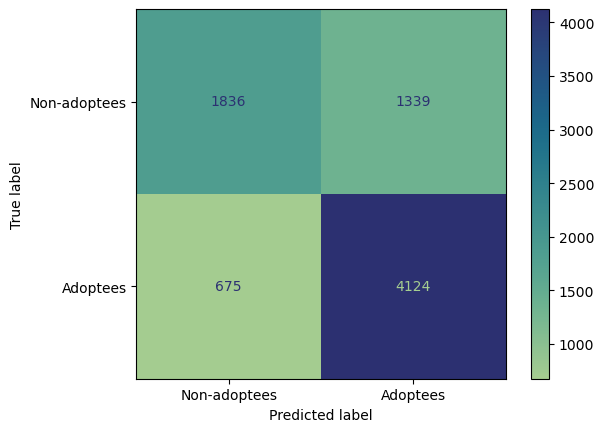

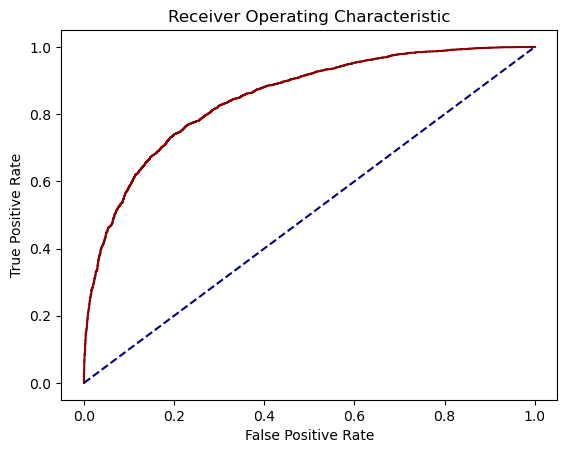

In [ ]:
# run 10-fold validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred_test = cross_val_predict(lr_clf, X_test, y_test, cv=kf)

### EVALUATION ###

# evaluation scores
report = classification_report(y_test, y_pred_test)
print(report)

# confusion matrix
con_mat = confusion_matrix(y_test, y_pred_test)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# this portion of the code was aided with the help of Chat GPT
# https://chat.openai.com/share/c4379ee5-9d59-4632-84aa-6a14b1aaec02

# find the y_probs
y_probs = lr_clf.predict_proba(X_test)[:, 1]
fprs, tprs, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fprs, tprs)
plt.figure()
plt.plot(fprs, tprs, color='darkred', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

Again we see very marginal improvements on the countvectorizer from before. This model is ever so slightly better for most scores.The same tradeoffs still apply.

### OPTIONAL: Ensemble Methods

Let's see if we can make our model more accurate

              precision    recall  f1-score   support

           0       0.69      0.36      0.47      3175
           1       0.68      0.89      0.77      4799

    accuracy                           0.68      7974
   macro avg       0.68      0.63      0.62      7974
weighted avg       0.68      0.68      0.65      7974
 



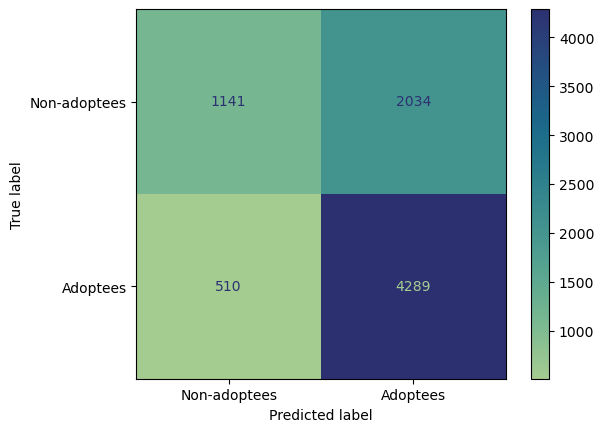

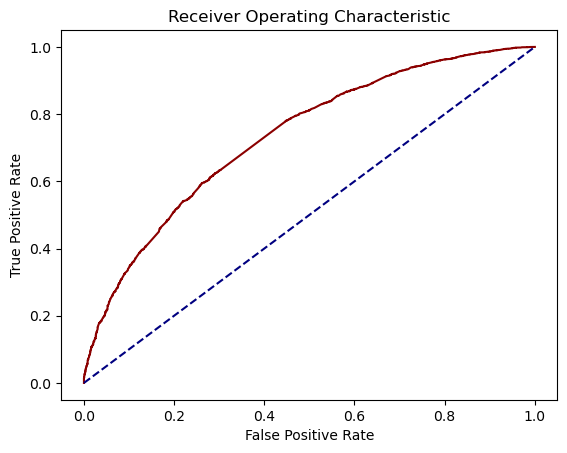

In [ ]:
boost_clf = AdaBoostClassifier(estimator=None, n_estimators=100, 
                               algorithm="SAMME", random_state=42).fit(X_train, y_train)

mod_eval(boost_clf, X_test, y_test)

We see that after performing boosting, the model performance is lower than any of the above models. This indicates a potential overfitting issue. 

# ERROR ANALYSIS

In [31]:
lr_clf = LogisticRegression(penalty=None).fit(X_train, y_train)


wrong = lr_clf.predict(X_test) != y_test

errors_df = all_df.loc[y_test.index[wrong]]

In [36]:
lr_clf.predict(X_test).size

7974

In [78]:
errors_df.columns

Index(['user', 'user_flair', 'post_date', 'post_flair', 'score', 'n_comments',
       'link', 'is_comment', 'subreddit', 'full_text', 'cleaner_text',
       'full_tokens', 'norm_tokens', 'tokens_sents', 'norm_sents', 'POS_sents',
       'is_adoptee', 'num_tokens', 'num_norm_tokens', 'sentiment'],
      dtype='object')

In [82]:
all_df.is_comment.value_counts()

is_comment
True     287462
False     14967
Name: count, dtype: int64

In [88]:
all_df.subreddit.value_counts()

subreddit
r/Adoption    285268
r/Adopted      17161
Name: count, dtype: int64

In [81]:
errors_df.is_comment.value_counts()

is_comment
True     2192
False      34
Name: count, dtype: int64

In [86]:
errors_df.subreddit.value_counts()

subreddit
r/Adoption    2121
r/Adopted      105
Name: count, dtype: int64

In [103]:
errors_df.num_tokens.describe()

count    2226.000000
mean      105.476190
std       123.150634
min        26.000000
25%        43.000000
50%        71.000000
75%       125.000000
max      3465.000000
Name: num_tokens, dtype: float64

In [114]:
all_df.num_tokens.describe()

count    302429.000000
mean         93.865350
std         125.245093
min           0.000000
25%          23.000000
50%          55.000000
75%         117.000000
max        5707.000000
Name: num_tokens, dtype: float64

If we wanted to be more strict and increase threshold of word count to 35 and only include posts, we would drastically reduce our data size to only around 900 rows to analyze

In [97]:
all_df[(~all_df.is_comment) & (all_df.is_adoptee < 2) & (all_df.num_tokens > 35)].shape

(877, 20)

In [102]:
for i, col in enumerate(errors_df.head(5).values):
    print(i, "|",f"{col[7]}" , "|",  col[16], "|", col[10])
    

0 | True | 1 | it might take a bit more than the two weeks of written communication theyve had out of the 20 years his daughter has existed and not been known to him to get to the stage of opening up about how adoption may have affected her.

also the way in which he is willing to communicate and bond at her pace had me thinking it was actually really sweet. he is asking questions and is willing to read about adoption/understand it. remembering that this is a birth father that didnt get the chance to be involved, the choice was made for him without his knowledge and as of now, yes he may only have his own feelings and thoughts but the relationship between him and his bio daughter has just started.
1 | True | 0 | thanks for sharing your story, op. it also highlights the differences in our culture regarding adoption. not a right way wrong way, but just that there are differences. you took the time to help someone educate themselves on american cultural just like you are learning about ch

Of particularly note, we see that a disproportionate amount of these texts that are mislabeled are comments. This ratio is nearly 4x more. We see that while some of these comments have positive. I thoought this might happen which is why I removed very short posts (25 or fewer words), but alas, the model is still performing poorly. we see the proportion for subreddit is not terribly different. I think this is largely an issue of not having enough textual data to make an informed decision. One way to do this would be to aggregate all user's posts together and then make a larger effort to classify based on this aggregate text. Furthermore, I could be more strict and not include comments at all. 